<a href="https://colab.research.google.com/github/MatheusABomfim/Qualifica-o_ML_HTLV/blob/main/MEST_HTLV%2BMBL2%2BCLINICAL_Hyperparameters_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the packages**

In [ ]:
# Install mango to bayesian optimization
!pip install arm-mango
!pip install --upgrade arm-mango

# Install Scikit-learn
!pip install scikit-learn

In [ ]:
# Import data and packages for work:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score,roc_curve, auc, make_scorer, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import pandas as pd
from scipy.stats import skew, kurtosis
import shutil
import os
from mango.tuner import Tuner
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings
warnings.filterwarnings('ignore')

# **Importing data**

**Importing models**

In [ ]:
# List of ML packages that we will run
classifiers = [
    LogisticRegression(solver="liblinear", random_state=42),
    KNeighborsClassifier(2),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
]

# Name of ML algorithms that we will use
names = [
    'Logistic Regression',
    'Nearest Neighbors',
    'Decision Tree',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
]

**Importing df**

In [ ]:
import pandas as pd

# Caminho completo para o arquivo CSV
csv_file_path = "/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Results_ML_MBL2_12_01_24/Data sets and Models/Processed_df.csv"

# Carregar o arquivo CSV em um DataFrame
df = pd.read_csv(csv_file_path)

# Adjust of columns names
df = df.rename(columns={'parestesia':'Parestesia'})
df = df.rename(columns={'dificuldade de deambular':'Dificuldade de deambular'})
df = df.rename(columns={'artrose':'Artrose'})

Separating the data frame in features and clinical outcome

In [ ]:
# Separate the variables into predictors and target variables (style);
y = df['HAM/TSP'] # Target variables;
x = df.drop('HAM/TSP', axis = 1) # Predict variables, without aim;

**Testing models**

In [ ]:
# Establishment of cross-validation and
skf = StratifiedKFold(5)

for item, nome in zip(classifiers, names):

# Testing the model
    for fold, (train_index, test_index) in enumerate(skf.split(x, y)): # metrics
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        item.fit(x_train, y_train)
    print(f'Model {nome} successfully tested')

Model Logistic Regression successfully tested
Model Nearest Neighbors successfully tested
Model Decision Tree successfully tested
Model Random Forest successfully tested
Model AdaBoost successfully tested
Model Gradient Boosting successfully tested
Model Naive Bayes successfully tested
Model Linear DA successfully tested


**Optimization of hyperparameters**

By Randomised searching

Optimization of decision tree:


In [ ]:
# Randomised searching for the best hyperparameters for decision tree
# Define the parameter grid by pre-pruning techniques
param_grid = {'criterion':["gini","entropy"],
'max_depth': [2, 3, 4, 5],
'min_samples_leaf': [10, 20, 30],
'min_samples_split': [20, 30, 40],}

# Create an instance of the DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Create an instance of the GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=skf)

# Fit the GridSearchCV to the data
grid_search.fit(x_train, y_train)

# Print the best set of hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20}


In [ ]:
# Searching the best hyperparameters for decision tree
# Calculate the pruning path by cost complexity
path = clf.cost_complexity_pruning_path(x, y)
alphas, impurities = path.ccp_alphas, path.impurities
print("Alphas:", alphas)

# Define the parameter grid with the alpha values
param_grid = {'ccp_alpha': alphas}

# Instantiate GridSearchCV with cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=skf)
grid_search.fit(x, y)

# Obtain the best alpha value
best_alpha = grid_search.best_params_['ccp_alpha']
print("Best Alpha:", best_alpha)

Alphas: [0.         0.00214141 0.01198257 0.01228178 0.02275494 0.05325625
 0.09325791]
Best Alpha: 0.0


In [ ]:
# Using bayesian optimization
def objective_dtree(args_list):
    global x_train, x_test, y_train, y_test

    f1_scores = []
    for hyper_par in args_list:
        clf = DecisionTreeClassifier(random_state=42)

        clf.set_params(**hyper_par)

        # Treine o classificador
        clf.fit(x_train, y_train)

        # Faça previsões no conjunto de teste
        y_pred = clf.predict(x_test)

        # Avalie o modelo usando o F1 score
        f1 = f1_score(y_test, y_pred)

        f1_scores.append(f1)
    return f1_scores

In [ ]:
# Parameter Search Space to find the best Tree
param_dict_dtree = {
              "criterion": ['gini', 'entropy', 'log_loss'],
              "splitter": ['best', 'random'],
              "min_samples_leaf": range(1,10),
              "max_features": ['sqrt', 'log2'],
               "max_depth": range(1,21),
               "min_samples_split": range(2,21)
             }

In [ ]:
# Using Mango
from mango.tuner import Tuner

tuner_user = Tuner(param_dict_dtree, objective_dtree)

results = tuner_user.maximize()

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Best parameters from the Search
print('best parameters:',results['best_params'])
print('best recall:',results['best_objective'])

best parameters: {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 16, 'splitter': 'random'}
best recall: 0.33333333333333337


Optimization of logistic regression

In [ ]:
# Using bayesian optimization
def objective_log_reg(args_list):
    global x_train, x_test, y_train, y_test

    f1_scores = []
    for hyper_par in args_list:
        clf = LogisticRegression(random_state=42)

        clf.set_params(**hyper_par)

        # Train the classifier
        clf.fit(x_train, y_train)

        # Make predictions on the test set
        y_pred = clf.predict(x_test)

        # Evaluate the model using the F1 score
        f1 = f1_score(y_test, y_pred)

        f1_scores.append(f1)
    return f1_scores

In [ ]:
# Defining the search space for the 'penalty' parameter only
param_grid = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none']
}

# Instantiating the logistic regression model
logistic_regression = LogisticRegression(random_state=42)

# Realizing grid search
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)

# Results
print("Melhor parâmetro penalty:", grid_search.best_params_)
print("Melhor F1 score encontrado:", grid_search.best_score_)


Melhor parâmetro penalty: {'penalty': 'none'}
Melhor F1 score encontrado: 0.8233766233766234


In [ ]:
# Parameter Search Space to find the best Tree
param_dict_log_reg = {
    "penalty": [None],
    "solver": ['saga', 'lbfgs', 'newton-cg', 'newton-cholesky', 'sag' ]  # 'liblinear' é adequado para 'l
}

In [ ]:
# Using Mango

tuner_user = Tuner(param_dict_log_reg, objective_log_reg)

results = tuner_user.maximize()

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Best parameters from the Search
print('best parameters:',results['best_params'])
print('best recall:',results['best_objective'])

best parameters: {'solver': 'newton-cg', 'penalty': None}
best recall: 0.3333333333333333


Implementation of hyperparameters


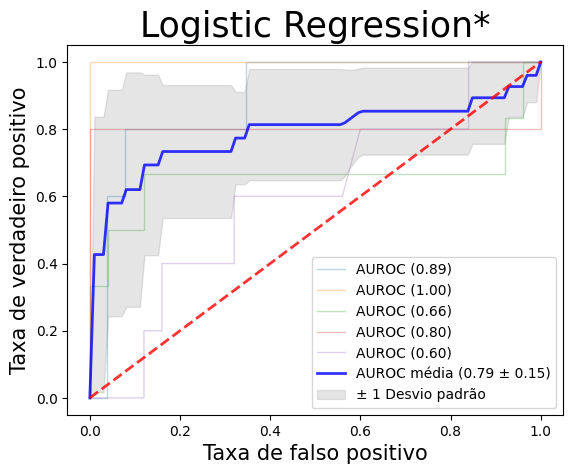

Média da precisão: 0.7733333333333333
Media do desvio padrão: 0.3143953632680425
Média da acurácia: 0.875483870967742
Media da taxa de recall: 0.4800000000000001
Media do parâmetro f1: 0.5567388167388168


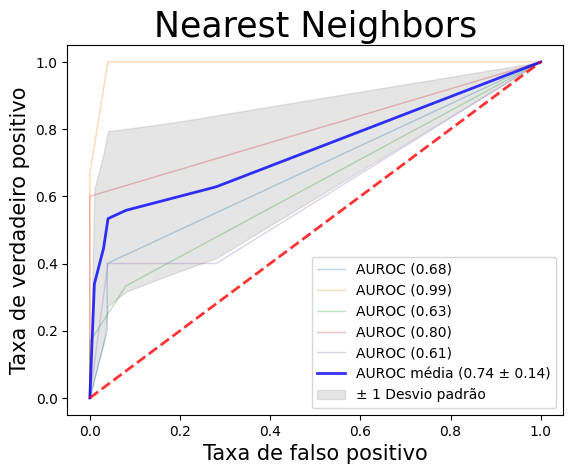

Média da precisão: 0.8333333333333334
Media do desvio padrão: 0.21081851067789195
Média da acurácia: 0.8759139784946235
Media da taxa de recall: 0.3666666666666667
Media do parâmetro f1: 0.4885714285714286


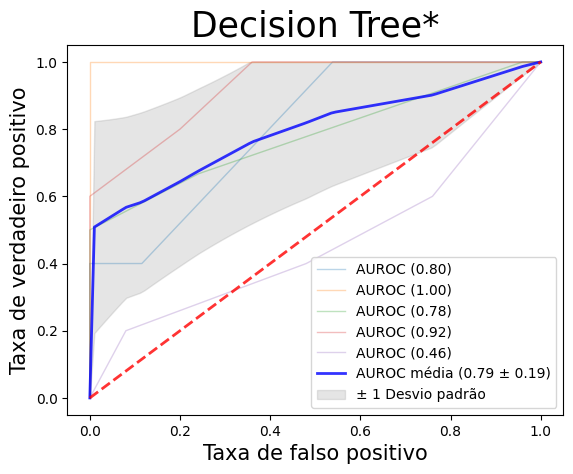

Média da precisão: 0.8666666666666666
Media do desvio padrão: 0.26666666666666666
Média da acurácia: 0.9079569892473118
Media da taxa de recall: 0.54
Media do parâmetro f1: 0.6476190476190476


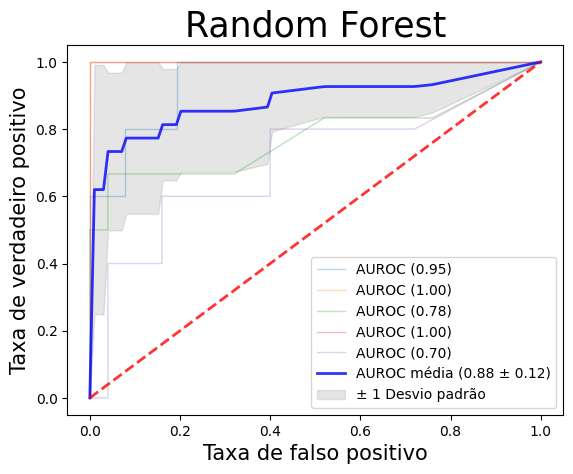

Média da precisão: 0.8357142857142857
Media do desvio padrão: 0.22542476911513573
Média da acurácia: 0.9015053763440861
Media da taxa de recall: 0.6266666666666667
Media do parâmetro f1: 0.6833333333333333


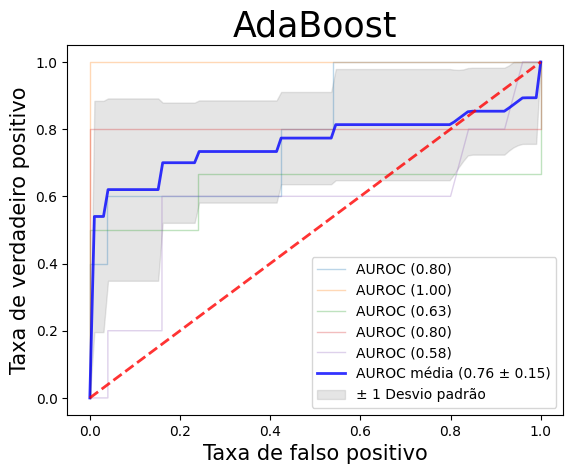

Média da precisão: 0.7866666666666667
Media do desvio padrão: 0.2745501370929867
Média da acurácia: 0.8883870967741936
Media da taxa de recall: 0.5866666666666667
Media do parâmetro f1: 0.657878787878788


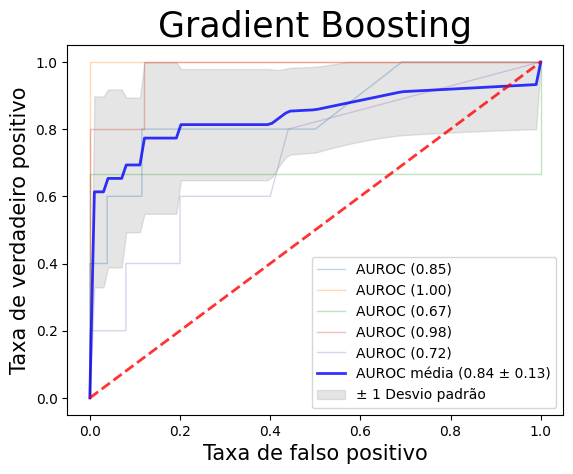

Média da precisão: 0.7771428571428571
Media do desvio padrão: 0.2904746291917448
Média da acurácia: 0.8883870967741936
Media da taxa de recall: 0.6266666666666667
Media do parâmetro f1: 0.6644444444444445


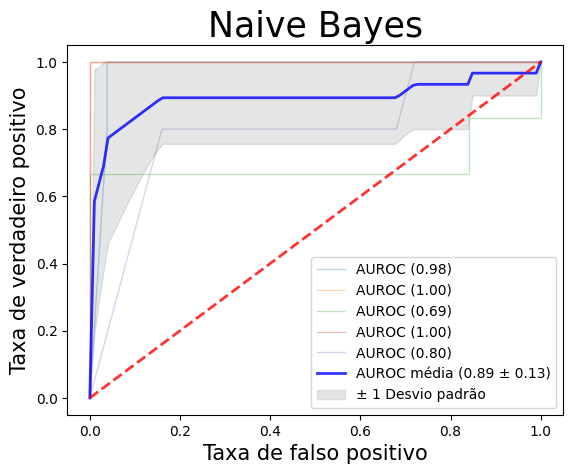

Média da precisão: 0.8466666666666667
Media do desvio padrão: 0.23247461032216923
Média da acurácia: 0.9273118279569893
Media da taxa de recall: 0.8533333333333333
Media do parâmetro f1: 0.8262626262626263


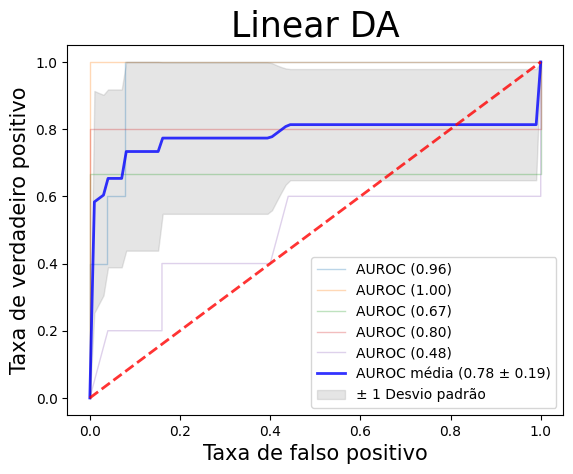

Média da precisão: 0.7777777777777778
Media do desvio padrão: 0.3063121944908938
Média da acurácia: 0.8683870967741937
Media da taxa de recall: 0.5933333333333333
Media do parâmetro f1: 0.6344155844155843


In [ ]:
# Clearing old data from the data_table, if the code has been run previously
data_table = pd.DataFrame()

# List of ML packages that we will run
classifiers = [
    LogisticRegression(solver="sag", random_state=42),
    KNeighborsClassifier(2),
    DecisionTreeClassifier(random_state = 42,
                           criterion ='gini',
                           splitter='random',
                           max_features='log2',
                           min_samples_split= 5,
                           max_depth= 5,
                           min_samples_leaf= 5),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

# Name of ML algorithms that we will use
names = [
    'Logistic Regression*',
    'Nearest Neighbors',
    'Decision Tree*',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
]

# Initialize StratifiedKFold and the lisst f1_m to f1 values
skf = StratifiedKFold(5)
f1_m = []

# Creating the avaliatives metrics for ROC curve
for item, nome in zip(classifiers, names):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

# Testing the model
    for fold, (train_index, test_index) in enumerate(skf.split(x, y)): # metrics
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        item.fit(x_train, y_train)

# Ploting avaliative metrics of ROC curve
        y_proba = item.predict_proba(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f"AUROC ({roc_auc:.2f})")
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=f"AUROC média ({mean_auc:.2f} ± {std_auc:.2f})", lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label='± 1 Desvio padrão')

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('Taxa de falso positivo', fontsize=15)
    plt.ylabel('Taxa de verdadeiro positivo', fontsize=15)
    plt.title(nome, fontsize=25)
    plt.legend(loc="lower right")
    plt.savefig('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Qualificação/ROC Curve/' + 'Curva ROC ' + nome + '.jpeg')
    plt.show()


# Calculation and print of F1 and associated metrics
    precision_mean_score = cross_val_score(item, x, y, scoring="precision", cv=5).mean()
    std_score = cross_val_score(item, x, y, scoring="precision", cv=5).std()
    accuracy_mean_score = cross_val_score(item, x, y, scoring="accuracy", cv=5).mean()
    recall_mean_score = cross_val_score(item, x, y, scoring="recall", cv=5).mean()
    f1_mean_score = cross_val_score(item, x, y, scoring="f1", cv=5).mean()

    print(f"Média da precisão: {precision_mean_score}")
    print(f"Media do desvio padrão: {std_score}")
    print(f"Média da acurácia: {accuracy_mean_score}")
    print(f"Media da taxa de recall: {recall_mean_score}")
    print(f"Media do parâmetro f1: {f1_mean_score}")

# Creating the data frames that  values to be saved
    results_mean_precision = pd.DataFrame({'Precision Mean': [precision_mean_score]})
    results_mean_accuracy = pd.DataFrame({'Accuracy Mean': [accuracy_mean_score]})
    results_mean_recall = pd.DataFrame({'Recall Mean': [recall_mean_score]})
    results_mean_f1 = pd.DataFrame({'F1 Mean': [f1_mean_score]})

# creating the data frames (with the values of interest) that will be plotted in txt file
    f1_metrics = pd.DataFrame(
    [{
        "Nome": nome,
        "Accuracy": results_mean_accuracy.iloc[0]['Accuracy Mean'],
        "Recall": results_mean_recall.iloc[0]['Recall Mean'],
        "Precision": results_mean_precision.iloc[0]['Precision Mean'],
        "F1 Score": results_mean_f1.iloc[0]['F1 Mean'],
    }]
)
    f1_m.append(f1_metrics)
    data_table = pd.concat(f1_m, ignore_index=True)
data_table = np.round(data_table.reset_index(drop=True), 2)

# Aesthetic transformation similar to a heatmap
styled_table = data_table.sort_values(by='F1 Score', ascending=False)\
      .style.background_gradient(cmap='coolwarm')\
      .bar(subset=['Recall'], color='#ff355d')\
      .bar(subset=['Precision'], color='lightseagreen')\
      .bar(subset=['F1 Score'], color='gold')\

# Save the generated excel file
styled_table.to_excel('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Qualificação/F1 metrics/'+"F1_metrics.xlsx", engine='openpyxl')

**Confunsion Matrix**

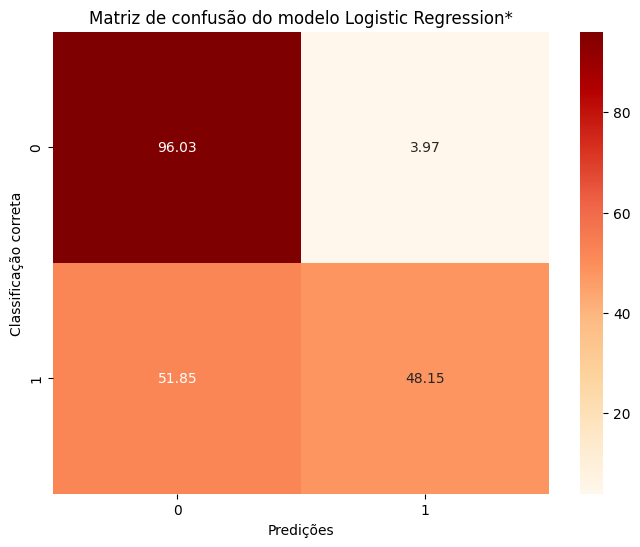

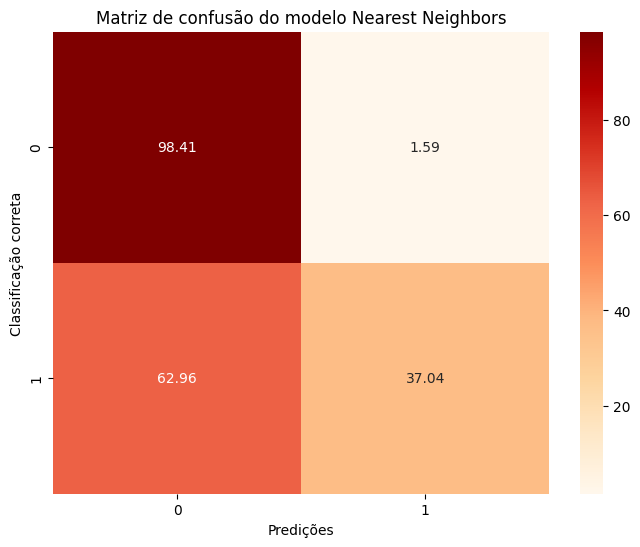

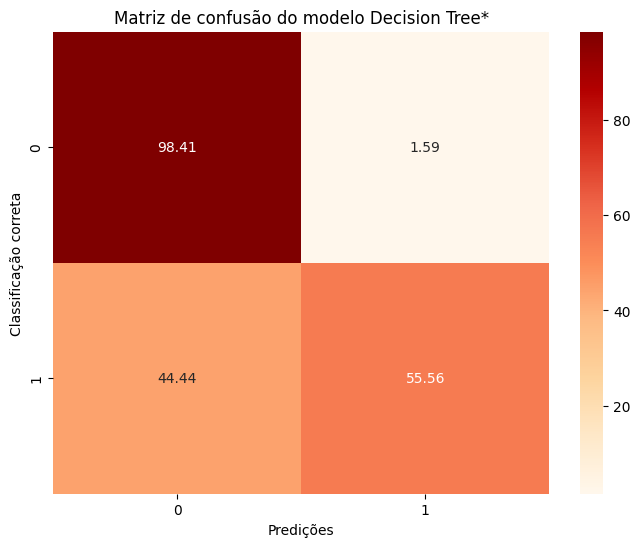

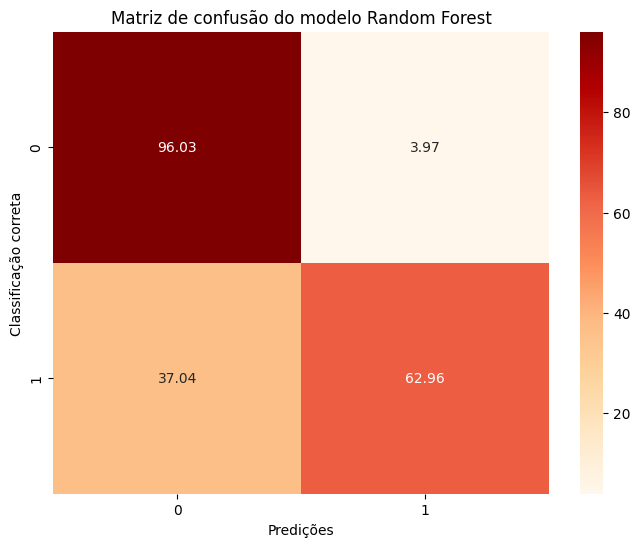

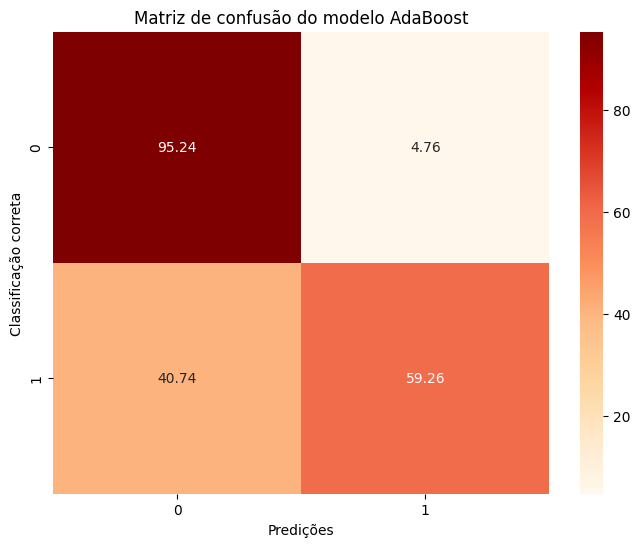

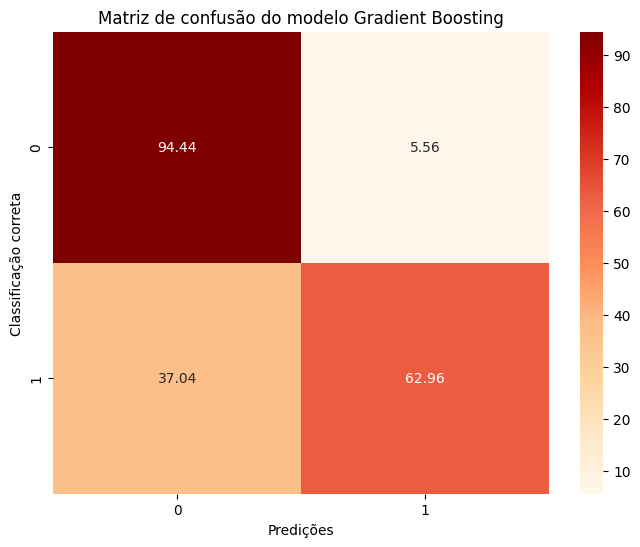

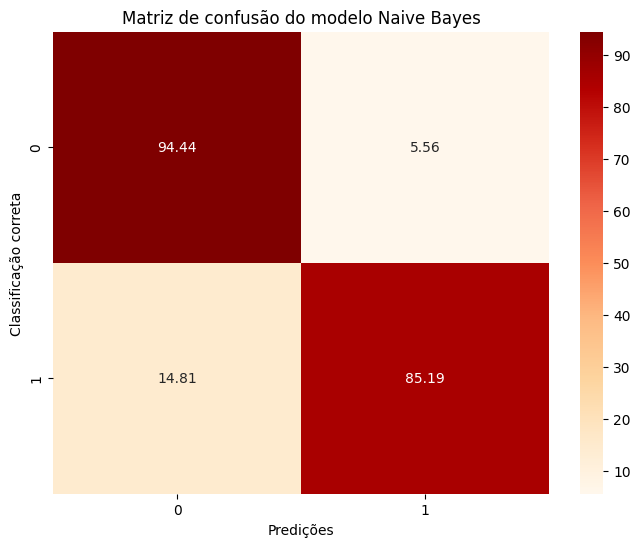

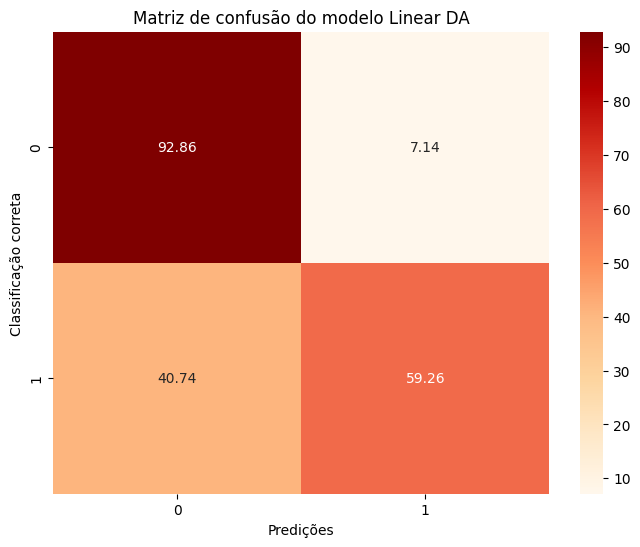

In [ ]:
# Initialize a dictionary to store the average confusion matrices of all the models
all_matrices = {}

# List of ML packages that we will run
classifiers = [
    LogisticRegression(solver="sag", random_state=42),
    KNeighborsClassifier(2),
    DecisionTreeClassifier(random_state = 42,
                           criterion ='gini',
                           splitter='random',
                           max_features='log2',
                           min_samples_split= 5,
                           max_depth= 5,
                           min_samples_leaf= 5),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

# Name of ML algorithms that we will use
names = [
    'Logistic Regression*',
    'Nearest Neighbors',
    'Decision Tree*',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
]


# Classifiers loop
for classifier, name in zip(classifiers, names):
    # Initialize a cumulative confusion matrix for this model
    cumulative_matrix = np.zeros((2, 2), dtype=int)

    # Folds (data set partitions)
    for fold, (train_index, test_index) in enumerate(skf.split(x, y)):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Training modelo
        classifier.fit(x_train, y_train)

        # Making predictions on the test set
        pred = classifier.predict(x_test)

        # Calculate the confusion matrix
        matriz = confusion_matrix(y_test, pred)

        # Add the confusion matrix to the cumulative
        cumulative_matrix += matriz

    # Calculate the average of the confusion matrix
    average_matrix = cumulative_matrix / skf.n_splits

    # Normalize the confusion matrix to obtain percentages
    row_sums = average_matrix.sum(axis=1, keepdims=True)
    normalized_matrix = (average_matrix / row_sums) * 100

    # Add the average to the matrix dictionary of all models
    all_matrices[name] = normalized_matrix

# Plot the average confusion matrix for each model
for name, matriz in all_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz, annot=True, cmap='OrRd', fmt='.2f')
    plt.xlabel('Predições')
    plt.ylabel('Classificação correta')
    plt.title(f'Matriz de confusão do modelo {name}')
    plt.savefig('/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Results_ML_MBL2_12_01_24/Qualificação/Confunsion matrix/' + f'Matriz de confusão {name}.jpeg')
    plt.show()

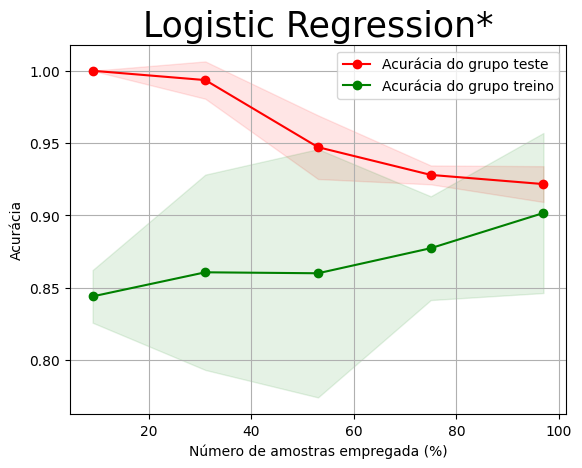

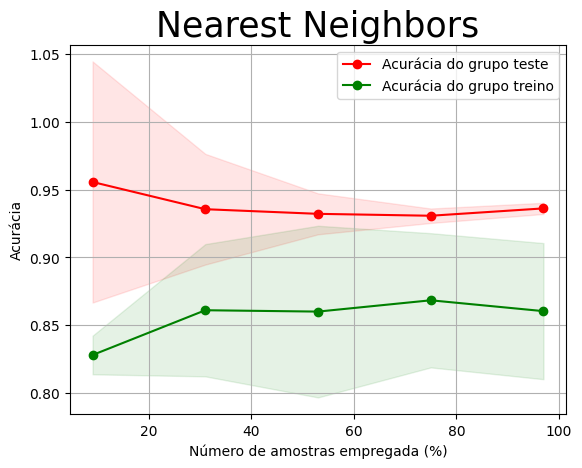

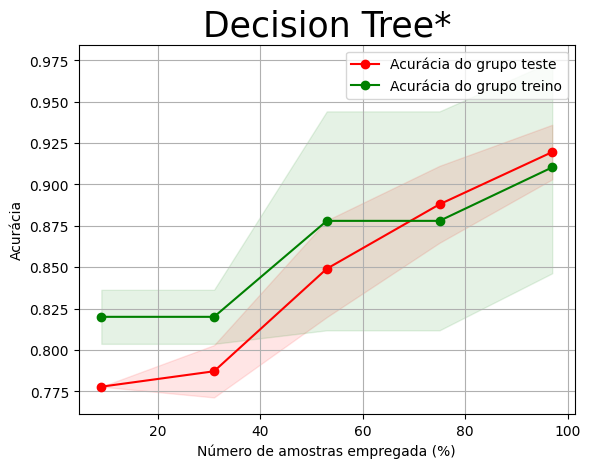

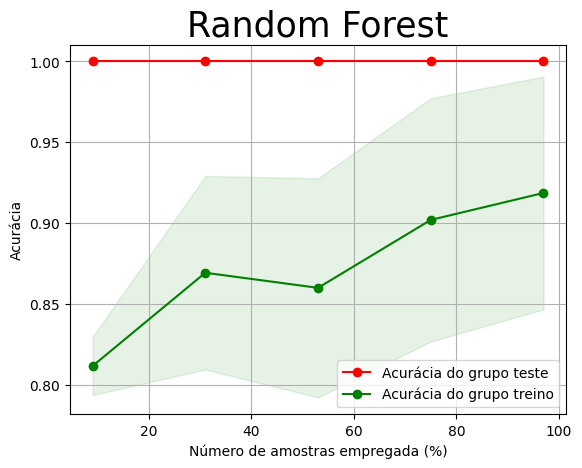

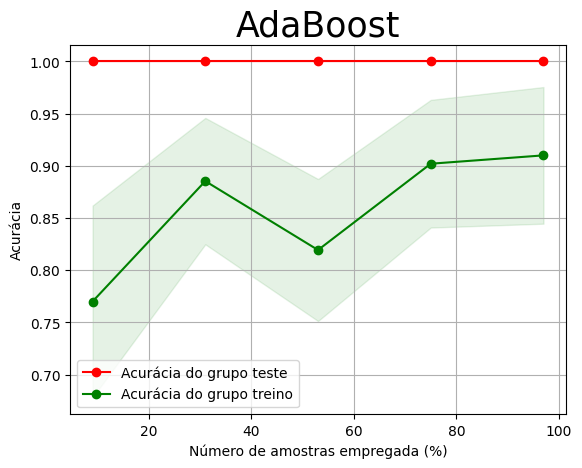

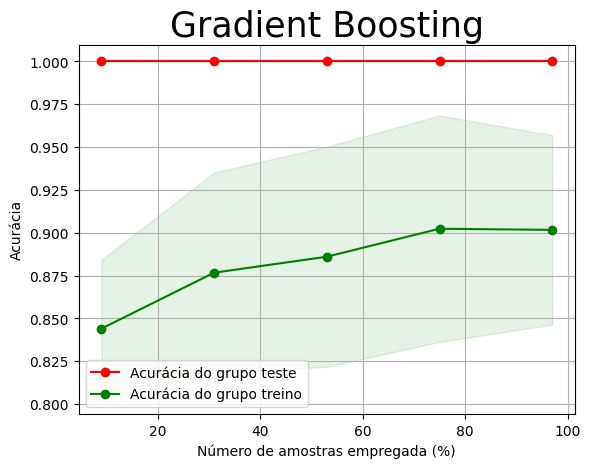

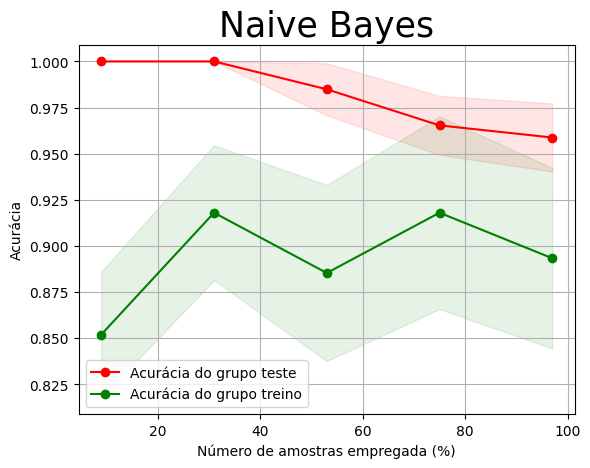

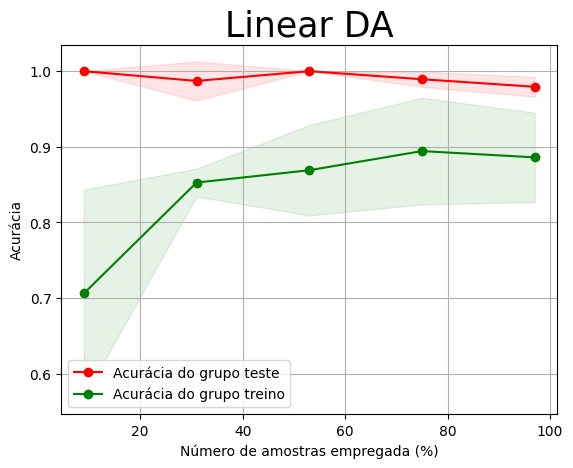

In [ ]:
# List of ML packages that we will run
# List of ML packages that we will run
classifiers = [
    LogisticRegression(solver="sag", random_state=42),
    KNeighborsClassifier(2),
    DecisionTreeClassifier(random_state = 42,
                           criterion ='gini',
                           splitter='random',
                           max_features='log2',
                           min_samples_split= 5,
                           max_depth= 5,
                           min_samples_leaf= 5),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
]

# Name of ML algorithms that we will use
names = [
    'Logistic Regression*',
    'Nearest Neighbors',
    'Decision Tree*',
    'Random Forest',
    'AdaBoost',
    'Gradient Boosting',
    'Naive Bayes',
    'Linear DA',
]

# Define the training set sizes for which you want to calculate the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)  # Here, we are dividing the range from 0.1 to 1.0 into 10 equal parts

for item, nome in zip(classifiers, names):
    train_scores_mean = []
    train_scores_std = []
    test_scores_mean = []
    test_scores_std = []

    # Divide the data into training and validation sets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, val_index in sss.split(x, y):
        x_train, x_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Calculate the learning curves
        train_sizes_abs, train_scores, test_scores = learning_curve(item, x_train, y_train, cv=5, scoring='accuracy')

        # Calculate the mean and standard deviation of the training and test scores
        train_scores_mean.append(np.mean(train_scores, axis=1))
        train_scores_std.append(np.std(train_scores, axis=1))
        test_scores_mean.append(np.mean(test_scores, axis=1))
        test_scores_std.append(np.std(test_scores, axis=1))

    # Plot the learning curve
    plt.figure()
    plt.title(nome, fontsize=25)
    plt.xlabel("Número de amostras empregada (%)")
    plt.ylabel("Acurácia")
    plt.grid()

    # Calculate the averages and standard deviations over all the splits
    train_scores_mean = np.mean(train_scores_mean, axis=0)
    train_scores_std = np.mean(train_scores_std, axis=0)
    test_scores_mean = np.mean(test_scores_mean, axis=0)
    test_scores_std = np.mean(test_scores_std, axis=0)

    plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
             label="Acurácia do grupo teste")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
             label="Acurácia do grupo treino")

    plt.legend(loc="best")
    plt.savefig(f'/content/drive/MyDrive/Mestrado/Códigos_Bioinfo_e_docs_relacionados(menos_Python_colab)/Qualificação/Learning Curves/Accuracy curve/Learning curve do modelo {nome}.jpeg')
    plt.show()